In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SCHMEE_HAHN_QRF_CONFIGSPACE,
    SVR_CONFIGSPACE,
    TOBIT_NN_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
)
from src.constant import (
    HO,
    PROCESSED_DATA_DIR,
    RANDOM_STATE_LIST,
    RESULTS_0_10_DIR,
    SOLVER_NUMBER_LIST,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import (
    SVR,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    SchmeeHahnQRF,
    TobitModel,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.results import plot_line, plot_scatter, wilcoxon_df
from src.split import get_n_splits
from src.wrapper import (
    ScikitLearnWrapper,
    SkipCutOffScikitLearnWrapper,
    StandardScaledLogTransformedWrapper,
    SurvivalFunctionWrapper,
    XGBwrapper,
)

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
# from src.instance.TSP_Instance import TSP_from_index_file, set_n22_cut_off_time
# from src.constant import DATA_DIR
# import json
# train_instances = TSP_from_index_file(
#     filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
# )
# train_instances = set_n22_cut_off_time(train_instances, reference_cut_off_time=10.0)
# instance_to_cut_off = {}
# for instance in train_instances:
#     key = instance._get_short_filepath()
#     instance_to_cut_off[key] = instance.cut_off_time
# with open("instance_to_cut_off.json", "w") as f:
#     json.dump(instance_to_cut_off, f, indent=4)

import json
with open("instance_to_cut_off.json", "r") as f:
    INSTANCE_TO_CUT_OFF = json.load(f)

(df["cost"] < df["instance_id"].map(INSTANCE_TO_CUT_OFF)).value_counts(normalize=True)

False    0.59602
True     0.40398
dtype: float64

In [4]:
SPLITS = get_n_splits(
    df=df,
    n=HO.N,
    instance_number=HO.INSTANCE_NUMBER,
    solver_number=HO.SOLVER_NUMBER,
    random_state=HO.RANDOM_STATE,
)

### Ridge

In [5]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "ridge_incumbent.pkl",
)

ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "ridge_incumbent_skip_cutoff.pkl",
)

### PolynomialRidge

In [6]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "poly_ridge_incumbent.pkl",
)

poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "poly_ridge_incumbent_skip_cutoff.pkl",
)

### RandomForestRegressor

In [7]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "rf_incumbent.pkl",
)

rf_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "rf_incumbent_skip_cutoff.pkl",
)

### XGBRegressor

In [8]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "xgb_incumbent.pkl",
)

xgb_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "xgb_incumbent_skip_cutoff.pkl",
)

### SVR

In [9]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "svr_incumbent.pkl",
)

svr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "svr_incumbent_skip_cutoff.pkl",
)

### GPRWithRBF

In [10]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "gpr_incumbent.pkl",
)

gpr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "gpr_incumbent_skip_cutoff.pkl",
)

### CoxPHSurvivalAnalysis

In [11]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "coxph_incumbent.pkl",
)
coxph_incumbent

{'alpha': 32.7658638422622,
 'risk_function': 'exponential',
 'ties': 'breslow',
 'risk_alpha': 4.9227443113732,
 'risk_beta': 21.7552044682021,
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [12]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "rsf_incumbent.pkl",
)
rsf_incumbent

{'max_depth': 12,
 'max_features': 0.9782283013351,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'linear',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [13]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "gb_cox_incumbent.pkl",
)
gb_cox_incumbent

{'ccp_alpha': 0.0010632091133,
 'learning_rate': 0.0709922107583,
 'loss': 'coxph',
 'max_depth': 11,
 'max_features': 0.604936786163,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 623,
 'random_state': 0,
 'risk_function': 'par10',
 'subsample': 0.7376034069785,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [14]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "xgb_aft_incumbent.pkl",
)
xgb_aft_incumbent

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.8117356962991,
 'eval_metric': 'aft-nloglik',
 'gamma': 0.5353688656962,
 'learning_rate': 0.0241392576093,
 'max_depth': 8,
 'min_child_weight': 1,
 'num_boost_round': 457,
 'objective': 'survival:aft',
 'reg_alpha': 0.0807388347681,
 'reg_lambda': 0.005466759938,
 'seed': 0,
 'subsample': 0.8740239912749,
 'aft_loss_distribution_scale': 1.1877990509245,
 'model_cls': src.model.XGBRegressorAFT}

### SchmeeHahnQRF

In [15]:
sh_qrf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SchmeeHahnQRF,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=SCHMEE_HAHN_QRF_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "sh_qrf_incumbent.pkl",
)
sh_qrf_incumbent

{'ccp_alpha': 2.9192635613669,
 'ccp_alpha_rf': 0.0024994373033,
 'k': 10,
 'max_depth': 10,
 'max_depth_rf': 12,
 'max_features': 0.4435521963687,
 'max_features_rf': 0.9445308000949,
 'min_samples_leaf': 3,
 'min_samples_leaf_rf': 7,
 'min_samples_split': 8,
 'min_samples_split_rf': 6,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': src.model.SchmeeHahnQRF}

### TobitModel

In [16]:
tobit_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=TobitModel,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=TOBIT_NN_CONFIGSPACE,
    splits=SPLITS,
    instance_to_cut_off=INSTANCE_TO_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_0_10_DIR / "HO" / "tobit_incumbent.pkl",
)
tobit_incumbent

{'base_lr': 0.0001336676338,
 'dropout': 0.429227066996,
 'momentum': 0.6727447289219,
 'n_epochs': 219,
 'scheduler_step_size_up': 867,
 'model_cls': src.model.TobitModel}

## Comparison

In [ ]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
        "name": "Ridge Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
        "name": "Polynomial Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
        "name": "Support Vector Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
        "name": "Gaussian Process Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
        "name": "Random Forest (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
        "name": "XGBoost (skip cut-off)"
    },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**sh_qrf_incumbent),
        "name": "S&H QRF"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**tobit_incumbent),
        "name": "NN Tobit"
    },
]
 
total_iterations = len(RANDOM_STATE_LIST) * len(SOLVER_NUMBER_LIST) * len(model_info_list)
pbar = tqdm(total=total_iterations, desc="Evaluating models")

records = []

for random_state in RANDOM_STATE_LIST:
    for solver_number in SOLVER_NUMBER_LIST:
        pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
        splits = get_n_splits(
            df,
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=random_state,
        )
        for model_info in model_info_list:
            pbar.set_postfix(model=model_info["name"])

            result = evaluate_model_with_cross_validation(
                df,
                wrapper=model_info["wrapper"],
                splits=splits,
                random_state=random_state,
                instance_to_cut_off=INSTANCE_TO_CUT_OFF,
            )
            result["random_state"] = random_state
            result["solver_number"] = solver_number
            result["name"] = model_info["name"]
            records.append(result)
            pbar.update(1)

pbar.close()
result_df = pd.DataFrame(records)
result_df.to_pickle(RESULTS_0_10_DIR / "results.gzip", compression="gzip")

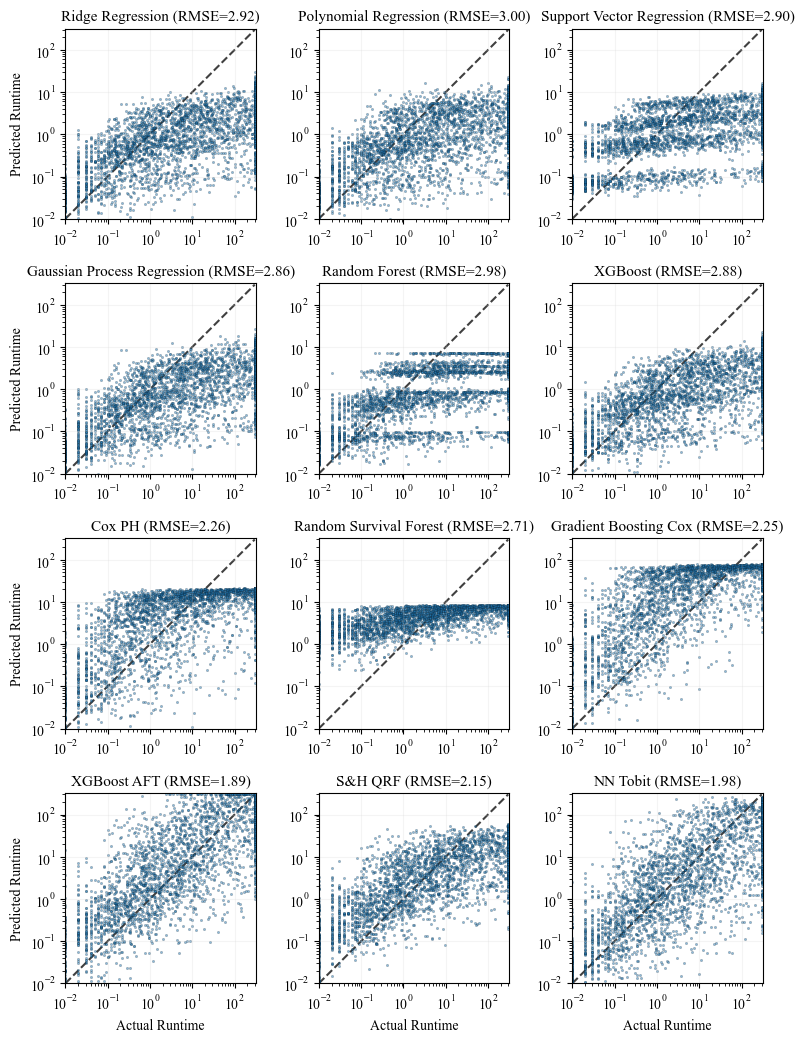

In [18]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17]].reset_index(drop=True)

fig, axs = plot_scatter(plot_df)
# plt.savefig("fig.png", dpi=200, bbox_inches="tight")
plt.show()

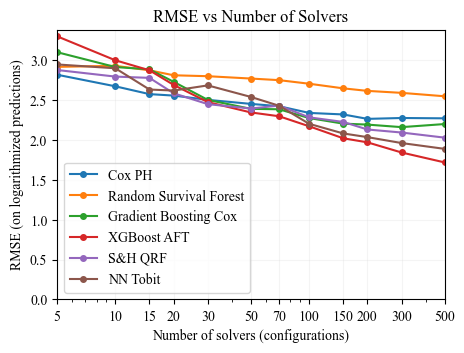

In [19]:
fig, ax = plot_line(
    result_df.loc[
        result_df["name"].isin(
            [
                "Cox PH",
                "Random Survival Forest",
                "Gradient Boosting Cox",
                "XGBoost AFT",
                "S&H QRF",
                "NN Tobit",
            ]
        )
    ]
)

# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

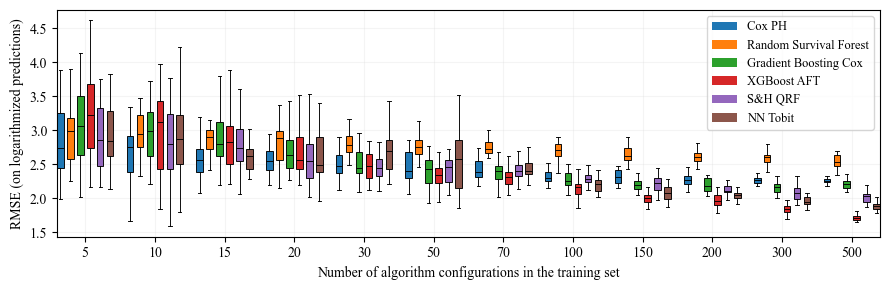

In [26]:
plot_df = result_df.loc[
    result_df["name"].isin(
        [
            "Cox PH",
            "Random Survival Forest",
            "Gradient Boosting Cox",
            "XGBoost AFT",
            "S&H QRF",
            "NN Tobit",
        ]
    )
]

fig, ax = plt.subplots(figsize=(9, 3))

# Get unique solver numbers and model names
solver_numbers = sorted(plot_df["solver_number"].unique())
model_names = plot_df["name"].unique()

# Create positions for boxplots
n_models = len(model_names)
width = 4
positions = []
labels = []

for i, solver_num in enumerate(solver_numbers):
    for j, model_name in enumerate(model_names):
        pos = i * (n_models + 1) + j
        positions.append(pos)
        
        # Get data for this model and solver number
        data = plot_df[(plot_df["solver_number"] == solver_num) & 
                      (plot_df["name"] == model_name)]["rmse"].values
        
        # Create boxplot
        bp = plt.boxplot(data, positions=[pos], widths=width/n_models, 
                patch_artist=True, manage_ticks=False, showfliers=False)
        
        # Color the boxplot based on model
        colors = plt.cm.tab10(j)
        bp['boxes'][0].set_facecolor(colors)
        
        # Set edge width
        for element in ['boxes', 'whiskers', 'fliers', 'caps']:
            if element in bp:
                for item in bp[element]:
                    item.set_linewidth(0.66)
        
        # Set median line width and color it to match box (to hide it)
        bp['medians'][0].set_linewidth(0.66)
        bp['medians'][0].set_color('black')

# Set x-axis labels
x_positions = [i * (n_models + 1) + (n_models - 1) / 2 for i in range(len(solver_numbers))]
plt.xticks(x_positions, solver_numbers)

# Create legend
handles = [plt.Rectangle((0,0),1,1, facecolor=plt.cm.tab10(i), alpha=1.0) 
          for i in range(n_models)]
plt.legend(handles, model_names, loc="best", frameon=True, fontsize=9)

plt.xlabel("Number of algorithm configurations in the training set")
plt.ylabel("RMSE (on logarithmized predictions)")
plt.tight_layout()
# plt.title("RMSE vs. the number of algorithm configurations in the training set")
plt.savefig("0_10_boxplot.pdf", bbox_inches="tight")
plt.show()

In [23]:
styled_result = wilcoxon_df(result_df, model_info_list)
styled_result

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,2.941,3.127,2.924,2.946,3.865,2.944,2.955,2.934,2.958,2.910,2.950,2.954
Polynomial Regression,2.961,3.112,3.042,3.059,3.174,3.100,3.119,3.114,3.108,3.042,3.015,2.958
Support Vector Regression,3.030,3.024,2.913,2.918,2.975,2.896,2.928,2.912,2.933,2.890,2.917,2.919
Gaussian Process Regression,2.950,3.098,2.938,2.928,3.033,2.940,2.952,2.925,2.937,2.883,2.907,2.891
Random Forest,2.977,3.153,3.072,2.974,3.095,2.996,3.040,2.993,2.998,2.947,2.970,2.983
XGBoost,2.991,3.106,3.052,2.969,3.095,2.992,3.014,2.958,2.949,2.900,2.898,2.883
Ridge Regression (skip cut-off),3.594,3.584,3.313,3.378,3.497,3.608,3.419,3.392,3.371,3.320,3.363,3.358
Polynomial Regression (skip cut-off),3.948,3.876,3.662,3.580,3.768,3.673,3.671,3.637,3.582,3.466,3.397,3.214
Support Vector Regression (skip cut-off),3.593,3.614,3.345,3.398,3.508,3.513,3.427,3.365,3.341,3.274,3.304,3.295


In [18]:
idx = [x["name"] for x in model_info_list]
# fit time
result_df.pivot_table(index="name", columns="solver_number", values="fit_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02
Polynomial Regression,0.01,0.02,0.02,0.33,0.64,0.82,1.21,1.50,2.44,3.46,6.05,12.25
Support Vector Regression,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.02,0.04,0.08,0.19,0.54
Gaussian Process Regression,0.00,0.00,0.01,0.56,1.11,1.47,2.07,2.68,4.24,5.80,9.21,16.83
Random Forest,0.14,0.16,0.19,0.21,0.25,0.34,0.46,0.58,0.84,1.07,1.58,2.60
XGBoost,0.17,0.17,0.18,0.19,0.21,0.24,0.25,0.26,0.28,0.30,0.33,0.35
Ridge Regression (skip cut-off),0.01,0.02,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
Polynomial Regression (skip cut-off),0.02,0.02,0.03,0.03,0.04,0.33,0.59,0.75,0.99,1.24,1.82,3.63
Support Vector Regression (skip cut-off),0.00,0.00,0.01,0.01,0.01,0.02,0.03,0.05,0.07,0.11,0.19,0.48


In [19]:
# predict time
result_df.pivot_table(index="name", columns="solver_number", values="predict_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Polynomial Regression,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.03
Support Vector Regression,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.04,0.10
Gaussian Process Regression,0.03,0.04,0.04,0.04,0.04,0.06,0.05,0.06,0.12,0.16,0.32,1.08
Random Forest,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04
XGBoost,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Ridge Regression (skip cut-off),0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.01
Polynomial Regression (skip cut-off),0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.03
Support Vector Regression (skip cut-off),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.05
